# This module provide functionality for converting parsed data into graphs

In [1]:
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import re
import networkx as nx
import joblib
tqdm.pandas()
from sklearn.model_selection import train_test_split

/home/af9562/.conda/envs/import/lib/python3.8/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
df = pd.read_json('../data/all_data_new.json', lines=True, orient="records")

In [5]:
df.head()

,classImports,extends,implements,name,package,packageImports,repo
0,[org.fourthline.cling.controlpoint.ActionCallb...,ActionCallback,[],GetExternalIPSync,plugins.UPnP2.actions,[],007pig/plugin-UPnP2
1,[org.fourthline.cling.controlpoint.ActionCallb...,ActionCallback,[],GetLinkLayerMaxBitRates,plugins.UPnP2.actions,[],007pig/plugin-UPnP2
2,"[org.fourthline.cling.UpnpService, org.fourthl...",,[],IGDSubscriptionCallback,plugins.UPnP2,[],007pig/plugin-UPnP2
3,[org.fourthline.cling.controlpoint.ActionCallb...,ActionCallback,[],GetCommonLinkProperties,plugins.UPnP2.actions,[],007pig/plugin-UPnP2
4,"[java.util.Set, java.util.concurrent.TimeUnit,...",,[],PortMappingTicker,plugins.UPnP2,[],007pig/plugin-UPnP2


## Some statistics about the number of files per repository

In [6]:
repo_sizes = {}
for x in tqdm(df.repo.values):
    repo_sizes[x] = repo_sizes.get(x, 0) + 1
sizes = np.array([x for x in repo_sizes.values()])

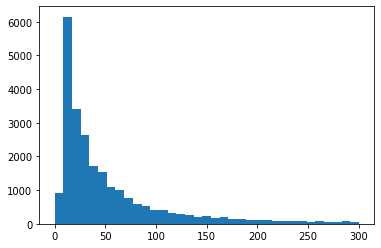

In [7]:
threshold = 300  # maximum repository size to display on the plot
plt.hist(sizes, bins=35, range=(0, threshold))
plt.show()

In [8]:
print("median: %d, mean: %f, less than %d: %f" 
      %(np.median(sizes), np.mean(sizes), threshold, np.count_nonzero(sizes < threshold) / len(sizes)))

median: 33, mean: 82.723774, less than 300: 0.952948


## Removing redicilously large repositories from the dataset

In [9]:
large_repos = {x for x in repo_sizes.keys() if repo_sizes[x] > threshold}

In [10]:
print("Total repos: %d, total files: %d, repos to be removed: %d" 
      %(len(df.repo.unique()), len(df), len(large_repos)))
df = df[~df.repo.isin(large_repos)]
print("Total repos: %d, total files: %d" %(len(df.repo.unique()), len(df)))

Total repos: 25461, total files: 2106230, repos to be removed: 1192
Total repos: 24269, total files: 1283271


## Loading word embeddings and defining functions to create classname embeddings

In [9]:
EMBEDDING_SIZE = 10

In [10]:
# most of the code in the cell is from Stackoverflow
GLOVE_FILE = '../data/glove.6B/glove.6B.' + str(EMBEDDING_SIZE) + 'd.txt'

# Get number of vectors and hidden dim
with open(GLOVE_FILE, 'r') as f:
    for i, line in tqdm(enumerate(f)):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1
assert(hidden_dim==EMBEDDING_SIZE)

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)
embeds = {}

with open(GLOVE_FILE, 'r') as f:
    for i, line in tqdm(enumerate(f)):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
        embeds[line.split(' ')[0]] = i

average_vec = np.mean(vecs, axis=0)

In [11]:
def camel_case_split(identifier):
    "copied from stackoverflow"
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

In [12]:
embed_stats = {"total": 0, "unsuccess": 0}

In [13]:
def get_embedding(classname):
    parts = camel_case_split(classname)
    embedding = np.zeros(EMBEDDING_SIZE, dtype=float)
    embed_stats["total"] += len(parts)
    for part in parts:
        if part.lower() in embeds:
            embedding[:EMBEDDING_SIZE] += vecs[embeds[part.lower()]]
        else:
            embedding[:EMBEDDING_SIZE] += average_vec
            embed_stats["unsuccess"] += 1
    embedding /= len(parts)
    return embedding

## Change the names of all extended\implemented classes to their fully-qualified names

In [14]:
def change_name(x, classes):
    if x in classes:
        return classes[x][0] + '.' + x
    if x.split('.') == 1 or x.split('.')[-1] not in classes:
        return ""
    curr_package = '.'.join(x.split('.')[:-1])
    curr_name = x.split('.')[-1]
    for package in classes[curr_name]:
        if curr_package in package:
            return package + '.' + curr_name
    return ""

In [15]:
def change_names(data):
    classes = {}
    for i in range(len(data)):
        if data.name.values[i] not in classes:
            classes[data.name.values[i]]= []
        classes[data.name.values[i]].append(data.package.values[i])
    for i in range(len(data)):
        data.extends.values[i] = change_name(data.extends.values[i], classes)
        data.implements.values[i] = [change_name(x, classes) for x in data.implements.values[i]]
        data.implements.values[i] = [x for x in data.implements.values[i] if x != ""]
    return data

In [16]:
first = 0

for i in tqdm(range(first, len(df))):
    if first == i:
        curr_repo = df.repo.values[first]
    if (i == len(df) - 1) or (df.repo.values[i+1] != curr_repo):
        df[first:i+1] = change_names(df[first:i+1])
        first = i + 1

## Converting repositories to graphs

In [17]:
def init_nodes(data, annotations, strings):
    ind = 0
    string_dict = {}
    for i in range(len(data)):
        full_name = data.package.values[i] + '.' + data.name.values[i]
        if full_name in strings:
            print(data.name.values[i], full_name, data.repo.values[0])
            assert(full_name not in strings)
        strings.append(full_name)
        annotations.append(np.zeros(EMBEDDING_SIZE * 2, dtype=float))
        annotations[-1][:EMBEDDING_SIZE] = get_embedding(data.name.values[i])
        string_dict[full_name] = ind
        ind += 1
    return string_dict

In [18]:
def init_edges(data, string_dict, edges, stats, annotations):
    

    classes = {}
    for i in range(len(data)):
        if data.name.values[i] not in classes:
            classes[data.name.values[i]]= []
    classes[data.name.values[i]].append(data.package.values[i])
        
    for i in range(len(data)): # for each compilation unit in the repository
        poss_imports = len(data) - 1  # number of CUs that could have been imported but were not
        edges_added = 0  # number of imported CUs
        from_name = data.package.values[i] + '.' + data.name.values[i] # the name of the given CUs
        from_ind = string_dict[from_name]  # its index
        classImports = set(data.classImports.values[i])
        for j in range(len(data)):
            to_name = data.package.values[j] + '.' + data.name.values[j] # the name of some othe CU
            to_ind = string_dict[to_name]
            if to_ind == from_ind:
                continue
            if data.package.values[i] == data.package.values[j]: # the same package -> import not possible
                poss_imports -= 1
                edges.append((from_ind, 2, to_ind))
            # either pacakge level import or class level import:
            elif data.package.values[j] in data.packageImports.values[i] or to_name in classImports:
                poss_imports -= 1
                if to_name == data.extends.values[i] or to_name in data.implements.values[i]:  # extends/implements
                    edges.append((from_ind, 3, to_ind))
                else:
                    edges_added += 1
                    edges.append((from_ind, 1, to_ind))
        stats += [poss_imports] * edges_added
        
        # updating annotations with information about external imports
        external_imports = 0
        e_imports_dict = {"", }
        for e_import in data.classImports.values[i]:
            if change_name(e_import, classes) == "" and e_import not in e_imports_dict:
                e_imports_dict.add(e_import)
                external_imports += 1
                annotations[from_ind][EMBEDDING_SIZE:] += get_embedding(e_import.split('.')[-1])
        if external_imports > 0:
            annotations[from_ind][EMBEDDING_SIZE:] /= external_imports

In [19]:
def repo_to_graph(data, init_nodes, init_edges):
    """
    Convert a repository to a graph such that can be easily stored 
    :param data: a fraction of df dataframe that contains information about the given repository
    :param init_nodes: a function to initialize the nodes
    :param init_edges: a function to initialize the edges
    :return:     a dictionary of the form "edges":[], "annotations":[], "targets": []
    """
    graph = {"edges":[], "annotations":[], "strings":[], "stats":[]}
    string_dict = init_nodes(data, graph["annotations"], graph["strings"])
    init_edges(data, string_dict, graph["edges"], graph["stats"], graph["annotations"])
    return graph

In [20]:
first = 0
graphs = []

for i in tqdm(range(first, len(df))):
    if first == i:
        curr_repo = df.repo.values[first]
    if (i == len(df) - 1) or (df.repo.values[i+1] != curr_repo):
        graph = repo_to_graph(df[first:i+1], init_nodes, init_edges)
        graph["repo"] = curr_repo
        graphs.append(graph)
        first = i + 1

In [21]:
# joblib.dump(graphs, "../data/allgraphs")

## Showing an example of a graph

In [22]:
# joblib.load(graphs, "../data/allgraphs")

In [23]:
# get the index of a given repository
repo = "0x277F/mopm"
repo_ind = 0
while repo != graphs[repo_ind]["repo"]:
    repo_ind += 1

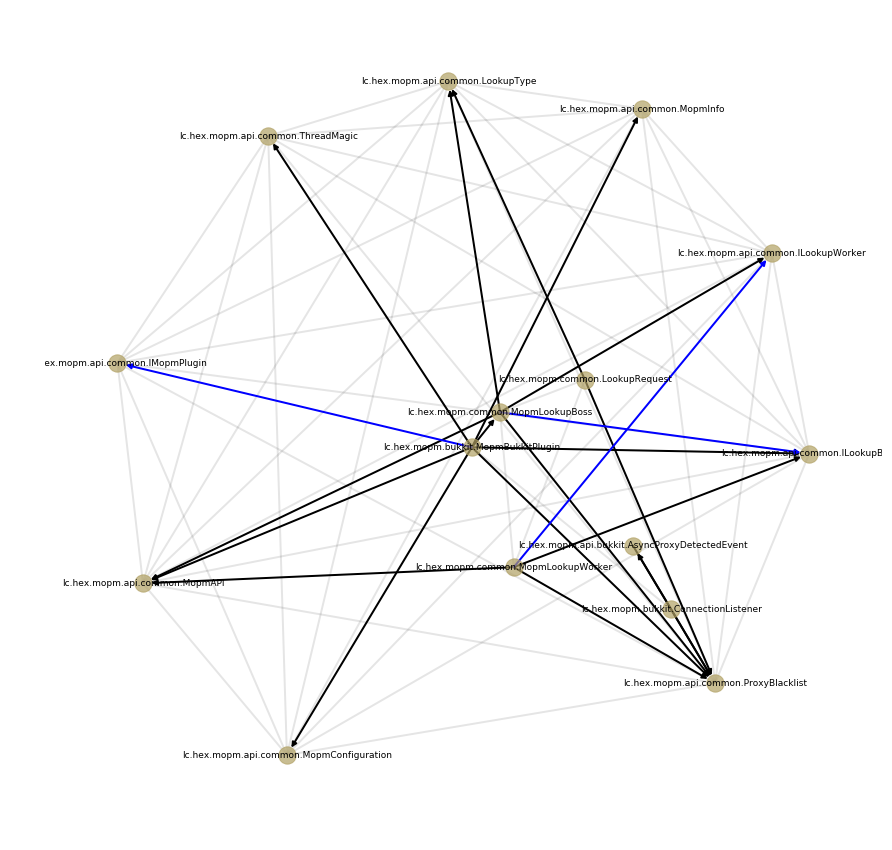

0x277F/mopm [10, 10, 13, 8, 8, 8, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 11, 11]


In [24]:
graph = graphs[repo_ind]
# graph = test[1]  # comment this out
G = nx.DiGraph()
G_extends = nx.DiGraph()
G_package = nx.Graph()
for i in range(len(graph["strings"])):
    node = graph["strings"][i]
    # node = i  # comment this out
    G.add_node(node)
    G_package.add_node(node)
    G_extends.add_node(node)
for edge in graph["edges"]:
    node_from = graph["strings"][edge[0]]
    node_to = graph["strings"][edge[2]]
    # node_from, _, node_to = edge  # comment this out
    if edge[1] == 1:
        G.add_edge(node_from, node_to)
    elif edge[1] == 2:
        G_package.add_edge(node_from, node_to)
    else:
        G_extends.add_edge(node_from, node_to)
nodelist = [x.split('.')[-1] for x in graph["strings"]]
pos=nx.spring_layout(G, k=0.7,iterations=100)
plt.figure(figsize = (15,15))
nx.draw_networkx_nodes(G,pos,
               nodelist=G.nodes,
               node_color='#B1A164',
               node_size=300,
               alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G,pos,alpha=1, width=2, arrows=True)
nx.draw_networkx_edges(G_package,pos,alpha=0.1, width=2, arrows=True)
nx.draw_networkx_edges(G_extends,pos,alpha=1, width=2, arrows=True, edge_color="b")
plt.axis('off')
plt.show()
print(graph["repo"], graph["stats"])

## Determining which graphs can be used for prediction purposes

In [25]:
def count_graphs(min_options):
    """
    Count the number of graphs that conform with the following criterion: 
    there is at least one node A that imports class B such that 
    class A could potentially import at least min_options additional classes
    """
    count = 0
    for i in range(len(graphs)):
        for x in graphs[i]["stats"]:
            if x >= min_options:
                count += 1
                break
    return count

In [26]:
print("Total graphs: %d\n 1 option: %d\n 5 options: %d\n 25 options: %d\n 125 options: %d" 
     %(len(graphs), count_graphs(1), count_graphs(4), count_graphs(24), count_graphs(124)))

Total graphs: 24269
 1 option: 21670
 5 options: 20914
 25 options: 12452
 125 options: 2478


In [27]:
graphs = [graph for graph in graphs if sum(graph["stats"]) > 0]
len(graphs)

21670

## Train-test split

In [28]:
train, test = train_test_split(graphs, test_size=0.1)

In [29]:
len(train), len(test)

(19503, 2167)

## Creating Targets for testing

In [30]:
def create_target(graph, n_options):
    possible_edge_ids = np.where(np.array(graph["stats"]) >= n_options)[0]
    if len(possible_edge_ids) == 0:
        return []
    edge_id = np.random.choice(possible_edge_ids)
    from_id, _, to_id = [x for x in graph["edges"] if x[1] == 1][edge_id]
    connected = {x[2] for x in graph["edges"] if x[0] == from_id}
    connected.add(from_id)
    all_options = [i for i in range(len(graph["annotations"])) if i not in connected]
    selected_options = np.random.choice(np.array(all_options), n_options)
    return [from_id, to_id] + list(selected_options)

In [31]:
for graph in tqdm(test):
    for n_options in (1, 4, 24, 124):
        graph["targets_" + str(n_options)] = create_target(graph, n_options)

In [32]:
for graph in tqdm(train):
    for n_options in (1, 4, 24, 124):
        graph["targets_" + str(n_options)] = create_target(graph, n_options)

In [33]:
joblib.dump(test, "../data/graphsTest")

['../data/graphsTest']

In [34]:
joblib.dump(train, "../data/graphsTrain")

['../data/graphsTrain']

In [2]:
test = joblib.load("../data/graphsTest50")
train = joblib.load("../data/graphsTrain50")

## Saving as Json file

In [35]:
# train = joblib.load("../data/graphsTrain")
# test = joblib.load("../data/graphsTest")

In [3]:
trainJson = {}
testJson = {}

In [4]:
for i in tqdm(range(len(train))):
    for key in train[i].keys():
        if key not in trainJson:
            trainJson[key] = []
        trainJson[key].append(train[i][key])

In [5]:
for i in tqdm(range(len(test))):
    for key in test[i].keys():
        if key not in testJson:
            testJson[key] = []
        testJson[key].append(test[i][key])

In [6]:
trainJson = pd.DataFrame(data=trainJson)
validJson = trainJson[:(int)(len(trainJson)/25)]
trainJson = trainJson[(int)(len(trainJson)/25):]
testJson = pd.DataFrame(data=testJson)

In [7]:
trainJson.to_json("../data/graphs/newMethod50/train.json", orient="records")
testJson.to_json("../data/graphs/newMethod50/test.json", orient="records")
validJson.to_json("../data/graphs/newMethod50/valid.json", orient="records")